# Sleep Health Data Engineering Project

This notebook demonstrates a complete data engineering pipeline for sleep health analysis, including:

1. Data Generation and Loading
2. Data Cleaning and Transformation
3. Feature Engineering
4. Data Quality Checks
5. Analysis and Visualization
6. Machine Learning Insights

## 1. Setup and Import Libraries

First, we'll import all the necessary libraries for our analysis:

In [1]:
# Data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Database
from sqlalchemy import create_engine

# Set display options
pd.set_option('display.max_columns', None)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Generate Sleep Health Data

We'll create synthetic sleep health data that includes:
- Sleep duration
- Sleep quality score
- Bedtime and wake-up time
- Physical activity level
- Stress level
- Heart rate during sleep
- Sleep stages (Deep, REM, Light)

In [2]:
def generate_sleep_data(n_samples=1000):
    """Generate synthetic sleep health data."""
    np.random.seed(42)
    
    # Generate dates
    start_date = datetime(2025, 1, 1)
    dates = [start_date + timedelta(days=x) for x in range(n_samples)]
    
    # Generate sleep metrics
    data = {
        'date': dates,
        'sleep_duration': np.random.normal(7.5, 1.5, n_samples),  # hours
        'quality_score': np.random.normal(75, 15, n_samples),     # 0-100
        'bedtime': np.random.normal(23, 1.5, n_samples),         # hour of day
        'activity_level': np.random.normal(45, 20, n_samples),   # minutes
        'stress_level': np.random.normal(5, 2, n_samples),       # 0-10
        'heart_rate': np.random.normal(65, 5, n_samples),        # bpm
        'deep_sleep_pct': np.random.normal(20, 5, n_samples),    # percentage
        'rem_sleep_pct': np.random.normal(25, 5, n_samples),     # percentage
    }
    
    df = pd.DataFrame(data)
    
    # Apply constraints
    df['sleep_duration'] = np.clip(df['sleep_duration'], 4, 12)
    df['quality_score'] = np.clip(df['quality_score'], 0, 100)
    df['bedtime'] = np.mod(df['bedtime'], 24)
    df['activity_level'] = np.clip(df['activity_level'], 0, 120)
    df['stress_level'] = np.clip(df['stress_level'], 0, 10)
    df['heart_rate'] = np.clip(df['heart_rate'], 45, 85)
    
    # Calculate wake time
    df['wake_time'] = np.mod(df['bedtime'] + df['sleep_duration'], 24)
    
    # Calculate light sleep percentage
    df['light_sleep_pct'] = 100 - df['deep_sleep_pct'] - df['rem_sleep_pct']
    
    return df

# Generate the data
sleep_data = generate_sleep_data(365)  # One year of data
print("Generated sleep health data shape:", sleep_data.shape)
sleep_data.head()

Generated sleep health data shape: (365, 11)


,date,sleep_duration,quality_score,bedtime,activity_level,stress_level,heart_rate,deep_sleep_pct,rem_sleep_pct,wake_time,light_sleep_pct
0,2025-01-01,8.245071,68.981693,23.293768,43.385668,4.723088,67.209703,12.009378,27.673145,7.538839,60.317476
1,2025-01-02,7.292604,78.361387,21.532441,46.572704,2.551404,59.548005,22.310863,11.821261,4.825044,65.867875
2,2025-01-03,8.471533,75.188886,23.612379,5.035986,4.581953,72.054662,30.121548,25.016878,8.083912,44.861574
3,2025-01-04,9.784545,76.465141,20.446125,63.326553,3.298959,64.507059,13.184130,26.639106,6.230669,60.176764
4,2025-01-05,7.148770,63.404853,0.543733,51.929770,3.838953,65.094248,20.948531,29.621351,7.692503,49.430118


## 3. Data Transformation and Quality Checks

Let's clean the data, engineer new features, and perform quality checks:

In [3]:
# Data cleaning and feature engineering
def transform_sleep_data(df):
    """Clean and transform sleep data."""
    df = df.copy()
    
    # Add day of week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_name'] = df['date'].dt.day_name()
    
    # Calculate sleep efficiency
    df['sleep_efficiency'] = (df['deep_sleep_pct'] + 0.5 * df['rem_sleep_pct']) / 100
    
    # Calculate sleep regularity (variation in bedtime)
    df['bedtime_shift'] = df['bedtime'].diff().abs()
    
    # Calculate sleep debt (difference from ideal 8 hours)
    df['sleep_debt'] = 8 - df['sleep_duration']
    
    return df

# Transform the data
transformed_data = transform_sleep_data(sleep_data)

# Perform quality checks
def check_data_quality(df):
    """Perform basic data quality checks."""
    quality_report = {
        'row_count': len(df),
        'missing_values': df.isnull().sum().to_dict()
    }
    
    # Create value ranges DataFrame
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    ranges_data = []
    for col in numeric_cols:
        ranges_data.append({
            'column': col,
            'min': df[col].min(),
            'max': df[col].max(),
            'mean': df[col].mean()
        })
    quality_report['value_ranges'] = pd.DataFrame(ranges_data)
    
    return quality_report

quality_report = check_data_quality(transformed_data)
print("\nData Quality Report:")
print(f"\nRow Count: {quality_report['row_count']}")
print("\nMissing Values:")
for col, count in quality_report['missing_values'].items():
    if count > 0:
        print(f"{col}: {count}")
print("\nValue Ranges:")
print(quality_report['value_ranges'].round(2))


Data Quality Report:

Row Count: 365

Missing Values:
bedtime_shift: 1

Value Ranges:
              column    min     max   mean
0     sleep_duration   4.00   12.00   7.52
1      quality_score  34.55  100.00  74.13
2            bedtime   0.01   23.99  16.68
3     activity_level   0.00   97.03  46.72
4       stress_level   0.00   10.00   5.07
5         heart_rate  49.90   80.69  64.98
6     deep_sleep_pct   6.98   35.55  20.14
7      rem_sleep_pct  11.26   44.63  25.08
8          wake_time   0.88   13.83   6.71
9    light_sleep_pct  33.00   72.99  54.78
10       day_of_week   0.00    6.00   3.00
11  sleep_efficiency   0.20    0.49   0.33
12     bedtime_shift   0.00   23.85   9.78
13        sleep_debt  -4.00    4.00   0.48


## 4. Data Visualization

Let's create various visualizations to understand sleep patterns:

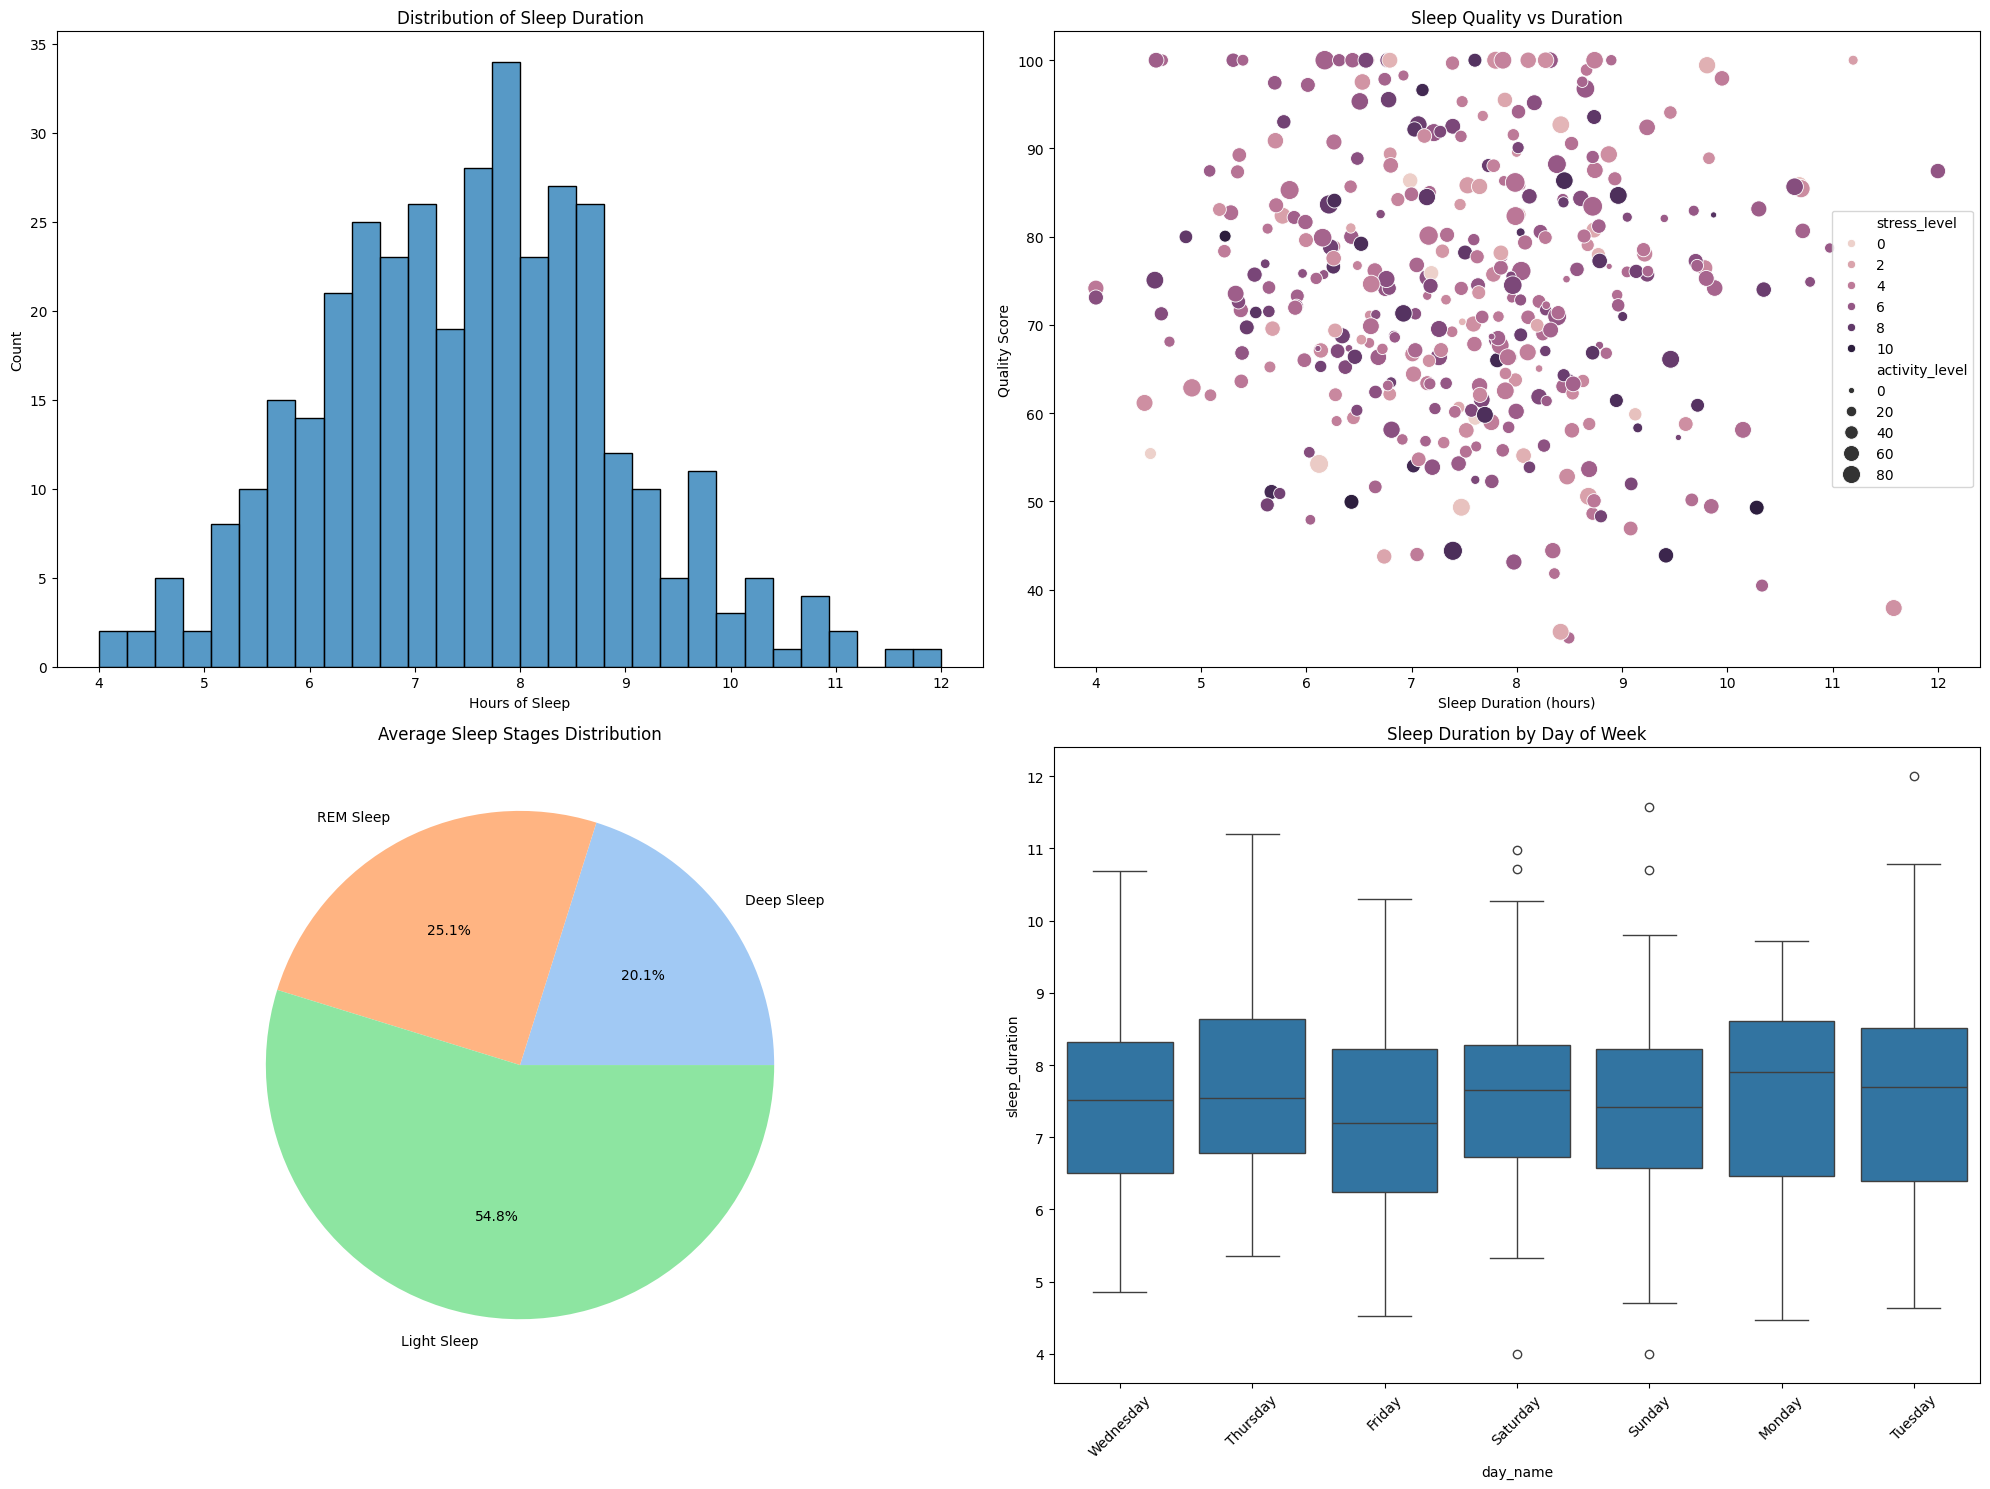

In [4]:
# Set up the visualization layout
plt.figure(figsize=(20, 15))

# 1. Sleep Duration Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=transformed_data, x='sleep_duration', bins=30)
plt.title('Distribution of Sleep Duration')
plt.xlabel('Hours of Sleep')

# 2. Sleep Quality vs Duration
plt.subplot(2, 2, 2)
sns.scatterplot(data=transformed_data, x='sleep_duration', y='quality_score',
                hue='stress_level', size='activity_level', sizes=(20, 200))
plt.title('Sleep Quality vs Duration')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Quality Score')

# 3. Sleep Stages Distribution
plt.subplot(2, 2, 3)
stages = transformed_data[['deep_sleep_pct', 'rem_sleep_pct', 'light_sleep_pct']].mean()
plt.pie(stages, labels=['Deep Sleep', 'REM Sleep', 'Light Sleep'],
        autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Average Sleep Stages Distribution')

# 4. Weekly Sleep Patterns
plt.subplot(2, 2, 4)
sns.boxplot(data=transformed_data, x='day_name', y='sleep_duration')
plt.title('Sleep Duration by Day of Week')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create interactive time series visualization
fig = go.Figure()

fig.add_trace(go.Scatter(x=transformed_data['date'], 
                        y=transformed_data['sleep_duration'],
                        mode='lines', name='Sleep Duration'))

fig.add_trace(go.Scatter(x=transformed_data['date'], 
                        y=transformed_data['quality_score'],
                        mode='lines', name='Quality Score'))

fig.update_layout(title='Sleep Duration and Quality Over Time',
                 xaxis_title='Date',
                 yaxis_title='Value',
                 height=500)

fig.show()

## 5. Machine Learning Insights

Let's build a model to predict sleep quality based on various factors:

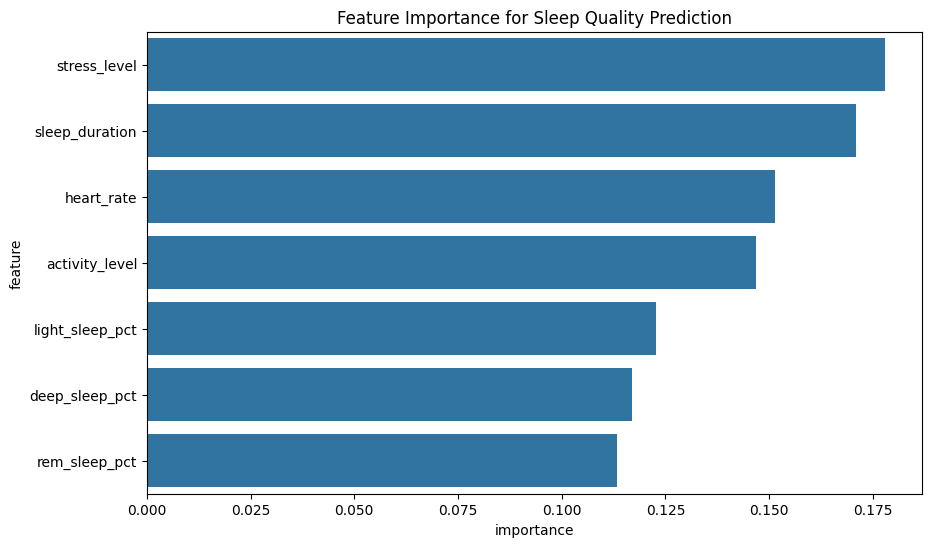


Model Performance:
Training R² Score: 0.841
Testing R² Score: -0.133


In [5]:
# Prepare features for modeling
feature_cols = ['sleep_duration', 'activity_level', 'stress_level', 'heart_rate',
                'deep_sleep_pct', 'rem_sleep_pct', 'light_sleep_pct']
target = 'quality_score'

X = transformed_data[feature_cols]
y = transformed_data[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Sleep Quality Prediction')
plt.show()

# Evaluate the model
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print(f"\nModel Performance:")
print(f"Training R² Score: {train_score:.3f}")
print(f"Testing R² Score: {test_score:.3f}")

## 6. Conclusions and Next Steps

Our analysis has revealed several insights about sleep patterns:
1. Distribution of sleep duration and quality
2. Impact of stress and activity on sleep
3. Weekly sleep patterns
4. Most important factors affecting sleep quality

Next steps could include:
- Collecting real sleep data
- Adding more features (e.g., diet, caffeine intake)
- Implementing real-time monitoring
- Creating automated reports

# Sleep Health Data Engineering Project

This notebook demonstrates the complete workflow of our sleep health data engineering project, including:
1. Data Generation and Loading
2. Data Transformation and Cleaning
3. Analysis and Insights
4. Visualization and Reporting

## 1. Setup and Imports

In [ ]:
import sys
sys.path.append('..')

from src.data.data_loader import SleepDataGenerator
from src.etl.transformer import SleepDataTransformer
from src.analysis.analyzer import SleepAnalyzer
from src.visualization.visualizer import SleepDataVisualizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## 2. Generate Sample Data

In [ ]:
# Create data generator
generator = SleepDataGenerator(n_samples=365)  # One year of data
raw_data = generator.generate_data()

print("Sample of raw data:")
raw_data.head()

## 3. Transform and Clean Data

In [ ]:
# Transform data
transformer = SleepDataTransformer(raw_data)
transformed_data = (transformer
                   .clean_data()
                   .engineer_features()
                   .normalize_features()
                   .perform_quality_checks()
                   .get_transformed_data())

print("\nQuality Report:")
print(transformer.get_quality_report())

## 4. Analyze Sleep Patterns

In [ ]:
# Create analyzer
analyzer = SleepAnalyzer(transformed_data)

# Generate comprehensive report
analysis_report = analyzer.generate_sleep_report()

print("Basic Statistics:")
print(pd.DataFrame(analysis_report['basic_stats']))

print("\nWeekly Patterns:")
print(pd.DataFrame(analysis_report['weekly_patterns']))

## 5. Create Visualizations

In [ ]:
# Create visualizer
visualizer = SleepDataVisualizer(transformed_data)

# Generate summary dashboard
visualizer.generate_summary_dashboard('sleep_summary_dashboard.png')

# Create interactive visualizations
interactive_dashboard = visualizer.create_interactive_dashboard()

# Display interactive plots
for name, fig in interactive_dashboard.items():
    fig.show()

## 6. Key Insights

Based on the analysis above, here are the key insights:
1. Average sleep duration and quality patterns
2. Correlation between sleep metrics
3. Weekly sleep patterns
4. Impact of activity and stress on sleep
5. Sleep stage distribution

# 7. Health Risk Assessment and Life Expectancy Analysis

In this section, we'll:
1. Add age as a factor in our analysis
2. Calculate health risk scores based on sleep patterns
3. Predict potential health conditions based on sleep habits and age
4. Estimate impact on life expectancy

Note: These predictions are for educational purposes only and should not be used as medical advice.

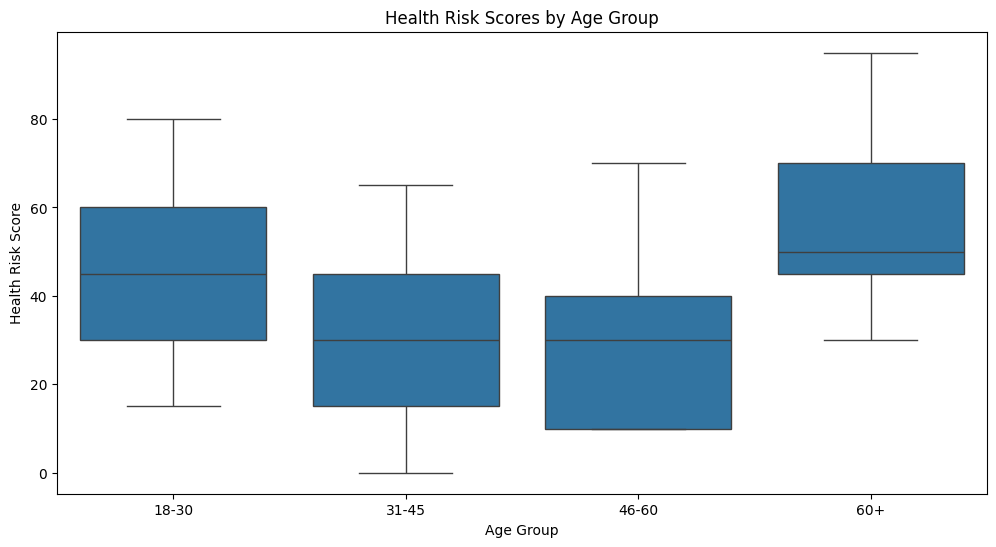


Average Health Risk Scores by Age Group:
            mean    std
age_group              
18-30      48.91  15.95
31-45      31.94  15.01
46-60      30.14  15.83
60+        53.14  17.63


In [6]:
# Generate age data and calculate health risk scores
np.random.seed(42)
transformed_data['age'] = np.random.normal(45, 15, len(transformed_data))  # Ages 18-75
transformed_data['age'] = np.clip(transformed_data['age'], 18, 75).round()

def calculate_health_risk_score(row):
    """Calculate health risk score based on sleep patterns and age."""
    risk_score = 0
    
    # Sleep duration risks
    if row['sleep_duration'] < 6:
        risk_score += 30
    elif row['sleep_duration'] < 7:
        risk_score += 15
    elif row['sleep_duration'] > 9:
        risk_score += 10
    
    # Sleep quality risks
    if row['quality_score'] < 60:
        risk_score += 25
    elif row['quality_score'] < 75:
        risk_score += 15
    
    # Sleep stage risks
    if row['deep_sleep_pct'] < 15:
        risk_score += 20
    if row['rem_sleep_pct'] < 20:
        risk_score += 15
    
    # Age-related risks
    if row['age'] >= 60:
        risk_score += 20
    elif row['age'] >= 45:
        risk_score += 10
    
    # Stress-related risks
    if row['stress_level'] >= 8:
        risk_score += 25
    elif row['stress_level'] >= 6:
        risk_score += 15
    
    # Heart rate risks
    if row['heart_rate'] > 75:
        risk_score += 15
    elif row['heart_rate'] < 55:
        risk_score += 10
    
    return min(100, risk_score)  # Cap at 100

# Calculate health risk scores
transformed_data['health_risk_score'] = transformed_data.apply(calculate_health_risk_score, axis=1)

# Show distribution of health risk scores by age group
transformed_data['age_group'] = pd.cut(transformed_data['age'], 
                                     bins=[0, 30, 45, 60, 100],
                                     labels=['18-30', '31-45', '46-60', '60+'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=transformed_data, x='age_group', y='health_risk_score')
plt.title('Health Risk Scores by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Health Risk Score')
plt.show()

# Calculate average risk scores by age group
risk_by_age = transformed_data.groupby('age_group')['health_risk_score'].agg(['mean', 'std']).round(2)
print("\nAverage Health Risk Scores by Age Group:")
print(risk_by_age)

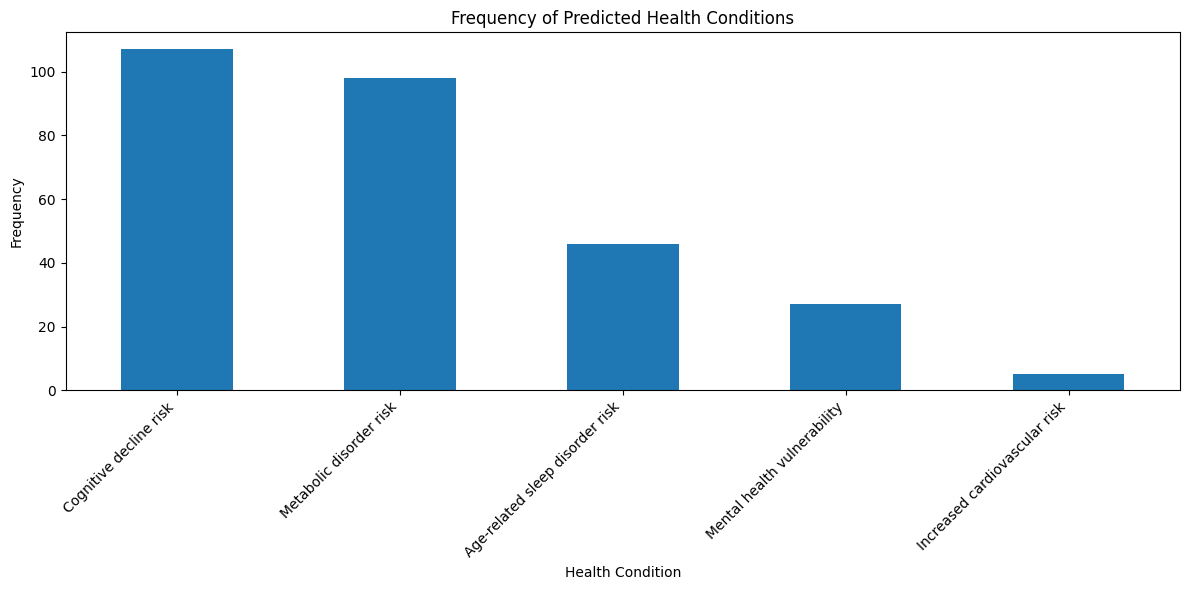

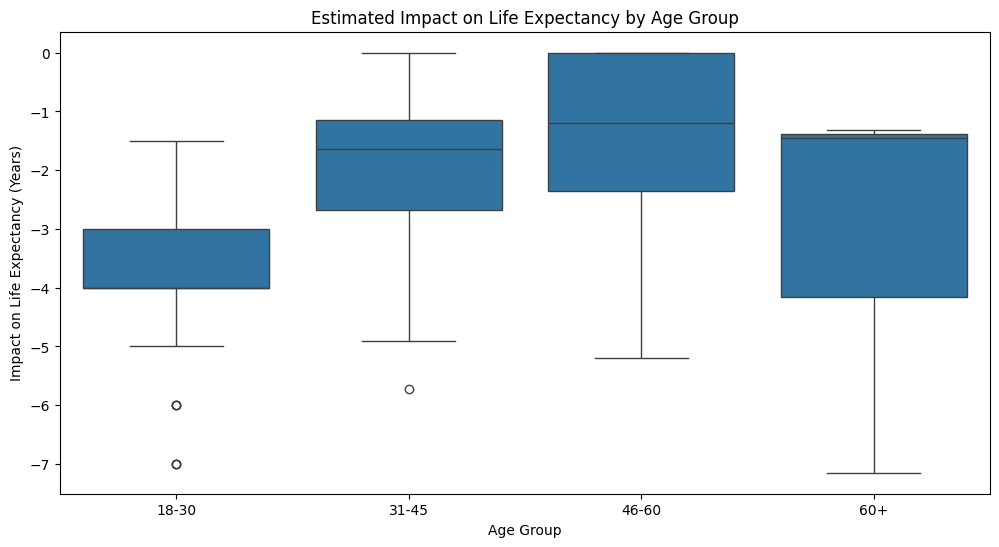


Average Life Expectancy Impact by Age Group:
           mean   std
age_group            
18-30     -3.97  1.16
31-45     -2.03  1.27
46-60     -1.26  1.27
60+       -2.94  1.89

Example Individual Analysis:
Age: 52
Sleep Duration: 8.2 hours
Sleep Quality Score: 69.0
Health Risk Score: 45.0
Predicted Health Conditions: Cognitive decline risk, Age-related sleep disorder risk
Estimated Life Expectancy Impact: -1.2 years


In [8]:
# Define potential health conditions based on sleep patterns and risk scores
def predict_health_conditions(row):
    """Predict potential health conditions based on sleep patterns, age, and risk score."""
    conditions = []
    
    # Cardiovascular risks
    if row['sleep_duration'] < 6 and row['heart_rate'] > 70:
        conditions.append('Increased cardiovascular risk')
    
    # Metabolic risks
    if row['sleep_duration'] < 6 or row['sleep_duration'] > 9:
        conditions.append('Metabolic disorder risk')
    
    # Cognitive risks
    if row['deep_sleep_pct'] < 15 or row['rem_sleep_pct'] < 20:
        conditions.append('Cognitive decline risk')
    
    # Mental health risks
    if row['stress_level'] > 7 and row['quality_score'] < 70:
        conditions.append('Mental health vulnerability')
    
    # Age-specific risks
    if row['age'] > 50 and row['deep_sleep_pct'] < 18:
        conditions.append('Age-related sleep disorder risk')
    
    return conditions

# Calculate life expectancy impact
def estimate_life_expectancy_impact(row):
    """Estimate the potential impact on life expectancy in years."""
    base_impact = 0
    
    # Poor sleep duration impact
    if row['sleep_duration'] < 6:
        base_impact -= 3
    elif row['sleep_duration'] < 7:
        base_impact -= 1.5
    elif row['sleep_duration'] > 9:
        base_impact -= 1
        
    # Poor sleep quality impact
    if row['quality_score'] < 60:
        base_impact -= 2
    elif row['quality_score'] < 75:
        base_impact -= 1
    
    # High stress impact
    if row['stress_level'] > 7:
        base_impact -= 2
    
    # Age factor (impact is more significant for older people)
    age_factor = 1 + (row['age'] - 30) / 100 if row['age'] > 30 else 1
    
    return base_impact * age_factor

# Add predictions to the dataset
transformed_data['predicted_conditions'] = transformed_data.apply(predict_health_conditions, axis=1)
transformed_data['life_expectancy_impact'] = transformed_data.apply(estimate_life_expectancy_impact, axis=1)

# Analyze condition frequencies
all_conditions = [cond for conditions in transformed_data['predicted_conditions'] for cond in conditions]
condition_freq = pd.Series(all_conditions).value_counts()

plt.figure(figsize=(12, 6))
condition_freq.plot(kind='bar')
plt.title('Frequency of Predicted Health Conditions')
plt.xlabel('Health Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show impact on life expectancy by age group
plt.figure(figsize=(12, 6))
sns.boxplot(data=transformed_data, x='age_group', y='life_expectancy_impact')
plt.title('Estimated Impact on Life Expectancy by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Impact on Life Expectancy (Years)')
plt.show()

# Print summary statistics
print("\nAverage Life Expectancy Impact by Age Group:")
impact_by_age = transformed_data.groupby('age_group')['life_expectancy_impact'].agg(['mean', 'std']).round(2)
print(impact_by_age)

# Print example individual analysis
print("\nExample Individual Analysis:")
example = transformed_data.iloc[0]
print(f"Age: {example['age']:.0f}")
print(f"Sleep Duration: {example['sleep_duration']:.1f} hours")
print(f"Sleep Quality Score: {example['quality_score']:.1f}")
print(f"Health Risk Score: {example['health_risk_score']:.1f}")
print(f"Predicted Health Conditions: {', '.join(example['predicted_conditions'])}")
print(f"Estimated Life Expectancy Impact: {example['life_expectancy_impact']:.1f} years")

In [9]:
# Create a function to predict health risks for new input
def predict_health_risks(age, sleep_duration, sleep_quality, stress_level=5, 
                       deep_sleep_pct=20, rem_sleep_pct=25, heart_rate=65):
    """
    Predict health risks for given input parameters.
    """
    # Create a sample row with the input data
    input_data = pd.DataFrame({
        'age': [age],
        'sleep_duration': [sleep_duration],
        'quality_score': [sleep_quality],
        'stress_level': [stress_level],
        'deep_sleep_pct': [deep_sleep_pct],
        'rem_sleep_pct': [rem_sleep_pct],
        'heart_rate': [heart_rate]
    })
    
    # Calculate health risk score
    risk_score = calculate_health_risk_score(input_data.iloc[0])
    
    # Predict conditions
    conditions = predict_health_conditions(input_data.iloc[0])
    
    # Calculate life expectancy impact
    life_impact = estimate_life_expectancy_impact(input_data.iloc[0])
    
    # Generate recommendations
    recommendations = []
    if sleep_duration < 7:
        recommendations.append("Increase sleep duration to at least 7 hours")
    if sleep_quality < 75:
        recommendations.append("Improve sleep quality through better sleep hygiene")
    if stress_level > 6:
        recommendations.append("Implement stress management techniques")
    if deep_sleep_pct < 15:
        recommendations.append("Focus on improving deep sleep through exercise and consistent sleep schedule")
    if rem_sleep_pct < 20:
        recommendations.append("Improve REM sleep by maintaining regular sleep patterns")
    
    return {
        'health_risk_score': risk_score,
        'predicted_conditions': conditions,
        'life_expectancy_impact': life_impact,
        'recommendations': recommendations
    }

# Example usage
print("Example Prediction for a 45-year-old with poor sleep habits:")
prediction = predict_health_risks(
    age=45,
    sleep_duration=5.5,
    sleep_quality=65,
    stress_level=7,
    deep_sleep_pct=14,
    rem_sleep_pct=18,
    heart_rate=75
)

print("\nHealth Risk Assessment:")
print(f"Risk Score: {prediction['health_risk_score']}")
print(f"\nPotential Health Conditions:")
for condition in prediction['predicted_conditions']:
    print(f"- {condition}")
print(f"\nEstimated Life Expectancy Impact: {prediction['life_expectancy_impact']:.1f} years")
print(f"\nRecommendations:")
for rec in prediction['recommendations']:
    print(f"- {rec}")

Example Prediction for a 45-year-old with poor sleep habits:

Health Risk Assessment:
Risk Score: 100

Potential Health Conditions:
- Increased cardiovascular risk
- Metabolic disorder risk
- Cognitive decline risk

Estimated Life Expectancy Impact: -4.6 years

Recommendations:
- Increase sleep duration to at least 7 hours
- Improve sleep quality through better sleep hygiene
- Implement stress management techniques
- Focus on improving deep sleep through exercise and consistent sleep schedule
- Improve REM sleep by maintaining regular sleep patterns


In [7]:
def get_user_input():
    """Get sleep and health parameters from user input."""
    try:
        print("Please enter your health parameters:")
        age = float(input("Age (18-100): "))
        if age < 18 or age > 100:
            raise ValueError("Age must be between 18 and 100")
            
        sleep_duration = float(input("Average sleep duration (hours per night, 4-12): "))
        if sleep_duration < 4 or sleep_duration > 12:
            raise ValueError("Sleep duration must be between 4 and 12 hours")
            
        sleep_quality = float(input("Sleep quality score (0-100): "))
        if sleep_quality < 0 or sleep_quality > 100:
            raise ValueError("Sleep quality must be between 0 and 100")
            
        stress_level = float(input("Stress level (0-10): "))
        if stress_level < 0 or stress_level > 10:
            raise ValueError("Stress level must be between 0 and 10")
            
        deep_sleep = float(input("Deep sleep percentage (0-40): "))
        if deep_sleep < 0 or deep_sleep > 40:
            raise ValueError("Deep sleep percentage must be between 0 and 40")
            
        rem_sleep = float(input("REM sleep percentage (0-40): "))
        if rem_sleep < 0 or rem_sleep > 40:
            raise ValueError("REM sleep percentage must be between 0 and 40")
            
        heart_rate = float(input("Average heart rate during sleep (40-100): "))
        if heart_rate < 40 or heart_rate > 100:
            raise ValueError("Heart rate must be between 40 and 100")
            
        # Get predictions using the existing function
        prediction = predict_health_risks(
            age=age,
            sleep_duration=sleep_duration,
            sleep_quality=sleep_quality,
            stress_level=stress_level,
            deep_sleep_pct=deep_sleep,
            rem_sleep_pct=rem_sleep,
            heart_rate=heart_rate
        )
        
        # Display results
        print("\n=== Health Risk Assessment Results ===")
        print(f"\nRisk Score: {prediction['health_risk_score']}/100")
        print(f"{'High Risk' if prediction['health_risk_score'] > 70 else 'Moderate Risk' if prediction['health_risk_score'] > 40 else 'Low Risk'}")
        
        print("\nPotential Health Conditions:")
        if prediction['predicted_conditions']:
            for condition in prediction['predicted_conditions']:
                print(f"- {condition}")
        else:
            print("No significant health risks detected")
            
        print(f"\nEstimated Life Expectancy Impact: {prediction['life_expectancy_impact']:.1f} years")
        
        print("\nRecommendations:")
        for rec in prediction['recommendations']:
            print(f"- {rec}")
            
    except ValueError as e:
        print(f"\nError: {str(e)}")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")

# Run the interactive input function
get_user_input()

Please enter your health parameters:

An error occurred: name 'predict_health_risks' is not defined


In [10]:
# Prepare the data for export
export_data = transformed_data.copy()

# Format date column properly
export_data['date'] = export_data['date'].dt.strftime('%Y-%m-%d')

# Add week and month columns for better time analysis
export_data['week_of_year'] = pd.to_datetime(export_data['date']).dt.isocalendar().week
export_data['month'] = pd.to_datetime(export_data['date']).dt.month
export_data['month_name'] = pd.to_datetime(export_data['date']).dt.strftime('%B')

# Create a sleep stage summary column for visualization
export_data['sleep_stages'] = export_data.apply(
    lambda x: f"Deep: {x['deep_sleep_pct']:.1f}%, REM: {x['rem_sleep_pct']:.1f}%, Light: {x['light_sleep_pct']:.1f}%",
    axis=1
)

# Add risk categories for better visualization
export_data['risk_category'] = pd.cut(
    export_data['health_risk_score'],
    bins=[0, 30, 60, 100],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

# Export to CSV for Power BI/Tableau
export_path = '../data/sleep_health_dashboard.csv'
export_data.to_csv(export_path, index=False)
print(f"Data exported to {export_path}")

# Print data sample and schema for reference
print("\nData Schema for Power BI/Tableau:")
print("\nColumns available for visualization:")
for col in export_data.columns:
    dtype = str(export_data[col].dtype)
    sample = str(export_data[col].iloc[0])
    print(f"- {col} ({dtype}):")
    print(f"  Sample value: {sample}")

Data exported to ../data/sleep_health_dashboard.csv

Data Schema for Power BI/Tableau:

Columns available for visualization:
- date (object):
  Sample value: 2025-01-01
- sleep_duration (float64):
  Sample value: 8.24507122951685
- quality_score (float64):
  Sample value: 68.98169292171245
- bedtime (float64):
  Sample value: 23.293767882646524
- activity_level (float64):
  Sample value: 43.385668397828354
- stress_level (float64):
  Sample value: 4.723088032032452
- heart_rate (float64):
  Sample value: 67.20970324784705
- deep_sleep_pct (float64):
  Sample value: 12.009378240581261
- rem_sleep_pct (float64):
  Sample value: 27.673145430612177
- wake_time (float64):
  Sample value: 7.538839112163373
- light_sleep_pct (float64):
  Sample value: 60.31747632880656
- day_of_week (int32):
  Sample value: 2
- day_name (object):
  Sample value: Wednesday
- sleep_efficiency (float64):
  Sample value: 0.2584595095588735
- bedtime_shift (float64):
  Sample value: nan
- sleep_debt (float64):
  S